In [1]:
# Data Manipulation
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nbformat

# Geospatial Analysis
import geopandas as gpd
import folium
from h3 import h3

# General-purpose
import numpy as np
import scipy

#My-SQL
import mysql.connector
from mysql.connector import Error

In [2]:
try:
    connection = mysql.connector.connect(host='localhost',
                                         database='gett_taxi_database',
                                         user='root',
                                         password='admin')
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)

Connected to MySQL Server version  8.0.34
You're connected to database:  ('gett_taxi_database',)


### A Query giving us access to the data in the data_orders table.

---

In [3]:
#The Query
sql_select_Query = "select * from data_orders"
cursor = connection.cursor()

# Execute the query
cursor.execute(sql_select_Query)

# Fetch the data
records = cursor.fetchall()

# Column names
column_names = [i[0] for i in cursor.description]

# Put the data into a pandas DataFrame
df = pd.DataFrame(records, columns=column_names)

# Don't forget to close the cursor and connection
cursor.close()
connection.close()

# Display the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_gk                       10716 non-null  int64  
 1   order_time                     10716 non-null  object 
 2   origin_longitude               10716 non-null  object 
 3   origin_latitude                10716 non-null  object 
 4   minutes_order_eta              2814 non-null   float64
 5   order_status_key               10716 non-null  object 
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 669.9+ KB


Question 3: Plot the average time to cancellation with and without driver, If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

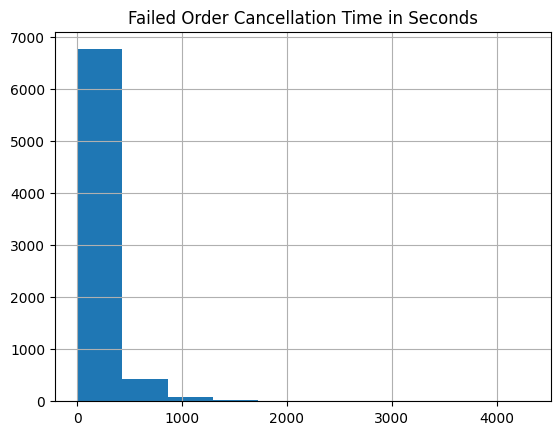

In [4]:
df['cancellations_time_in_seconds'].hist()
plt.title("Failed Order Cancellation Time in Seconds")
plt.show()

It appears that the majority of cancellations occur within a time frame ranging from 0 seconds to 1,100 seconds. The next step is to remove outliers.

In [5]:
df['cancellations_time_in_seconds'].describe()

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

75% of the data falls between 45 seconds and 187.5 seconds.

In [6]:
Q1 = df['cancellations_time_in_seconds'].quantile(0.25)
Q3 = df['cancellations_time_in_seconds'].quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")

Q1: 45.0, Q3: 187.5, IQR: 142.5


In [7]:
# Define bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(lower_bound,upper_bound)

-168.75 401.25


Removing Outliers

In [8]:
# Identify outliers and create boolean mask
outliers = (df['cancellations_time_in_seconds'] < lower_bound) | (df['cancellations_time_in_seconds'] > upper_bound)

# Remove outliers
df_filtered = df[~outliers]

In [9]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10124 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_gk                       10124 non-null  int64  
 1   order_time                     10124 non-null  object 
 2   origin_longitude               10124 non-null  object 
 3   origin_latitude                10124 non-null  object 
 4   minutes_order_eta              2289 non-null   float64
 5   order_status_key               10124 non-null  object 
 6   is_driver_assigned_key         10124 non-null  int64  
 7   cancellations_time_in_seconds  6715 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 711.8+ KB


In [10]:
driverWasAssigned = df_filtered.query('is_driver_assigned_key == 1')
noDriverWasAssigned = df_filtered.query('is_driver_assigned_key == 0')

print(driverWasAssigned.shape)
print(noDriverWasAssigned.shape)

(2289, 8)
(7835, 8)


## Plotting the Data

---

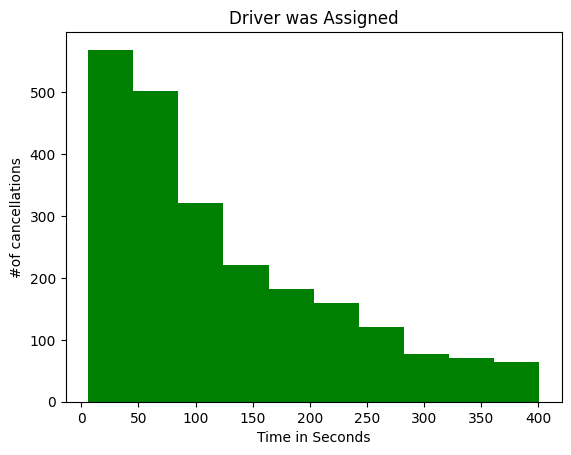

In [24]:
plt.hist(driverWasAssigned['cancellations_time_in_seconds'], color='green')
plt.title('Driver was Assigned')
plt.ylabel("#of cancellations")
plt.xlabel("Time in Seconds")
plt.show()

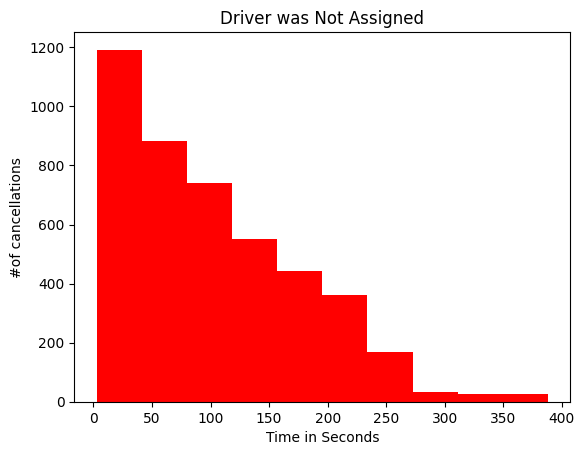

In [23]:
plt.hist(noDriverWasAssigned['cancellations_time_in_seconds'], color='red')
plt.title('Driver was Not Assigned')
plt.ylabel("#of cancellations")
plt.xlabel("Time in Seconds")
plt.show()

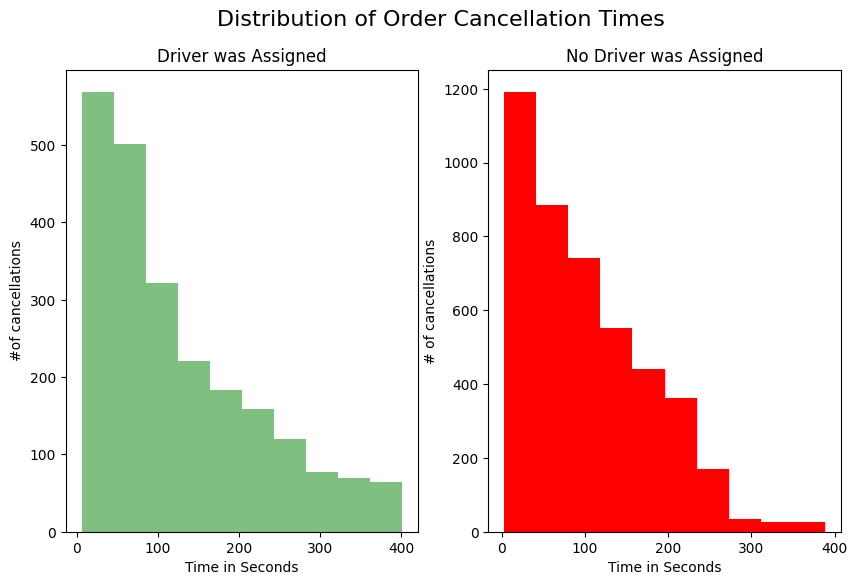

In [25]:
# Create a figure and a set of subplots (here, 1 row and 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Create the first histogram on the first subplot
axs[0].hist(driverWasAssigned['cancellations_time_in_seconds'], color='green', alpha=0.5)
axs[0].set_title('Driver was Assigned')
axs[0].set_xlabel('Time in Seconds')
axs[0].set_ylabel('#of cancellations')

# Create the second histogram on the second subplot
axs[1].hist(noDriverWasAssigned['cancellations_time_in_seconds'], color='red')
axs[1].set_title('No Driver was Assigned')
axs[1].set_xlabel('Time in Seconds')
axs[1].set_ylabel('# of cancellations')

# Add a main title to the entire figure
fig.suptitle('Distribution of Order Cancellation Times', fontsize=16)

# Show the plot
plt.show()

The time it takes for clients to cancel their orders appears to be consistent, whether or not a driver has been assigned.

Intriguingly, the cancellation rate soars by more than 200% when clients are not paired with a driver, compared to when they are.

In the data set, 2,286 orders failed without a driver assignment, while a noticeably higher 4,429 orders failed when a driver was indeed assigned.

Assigning a driver to a client significantly reduces the likelihood of the client cancelling their order, making for less cancellations.

Checking the numbers to make sure the correct data has been plotted.

In [15]:
noDriverWasAssigned.shape

(7835, 8)

In [16]:
driverWasAssigned.shape

(2289, 8)

In [17]:
df_filtered['cancellations_time_in_seconds'].describe()

count    6715.000000
mean      109.067312
std        84.834514
min         3.000000
25%        41.000000
50%        88.000000
75%       161.000000
max       401.000000
Name: cancellations_time_in_seconds, dtype: float64

All good.